In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image


In [23]:
class NoisyImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise_type="gaussian", noise_amount=0.1):
        self.root_dir = root_dir
        self.transform = transform
        self.noise_type = noise_type
        self.noise_amount = noise_amount
        self.images = []

        # Recursively add all images in subdirectories
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(root, file))
        
        print(f"Found {len(self.images)} images in {root_dir}")

        if len(self.images) == 0:
            raise ValueError(f"No images found in directory: {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        noisy_image = random_noise(image.numpy(), mode=self.noise_type, var=self.noise_amount)
        noisy_image = torch.from_numpy(noisy_image).float()
        return noisy_image, image


In [24]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # To bring the output in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Found 485 images in /kaggle/input/near-infrared-hyperspectral-image
Epoch [1/10], Train Loss: 0.0412, Val Loss: 0.0092
Epoch [2/10], Train Loss: 0.0080, Val Loss: 0.0061
Epoch [3/10], Train Loss: 0.0057, Val Loss: 0.0032
Epoch [4/10], Train Loss: 0.0028, Val Loss: 0.0025
Epoch [5/10], Train Loss: 0.0022, Val Loss: 0.0015
Epoch [6/10], Train Loss: 0.0019, Val Loss: 0.0014
Epoch [7/10], Train Loss: 0.0017, Val Loss: 0.0012
Epoch [8/10], Train Loss: 0.0015, Val Loss: 0.0011
Epoch [9/10], Train Loss: 0.0015, Val Loss: 0.0011
Epoch [10/10], Train Loss: 0.0018, Val Loss: 0.0011


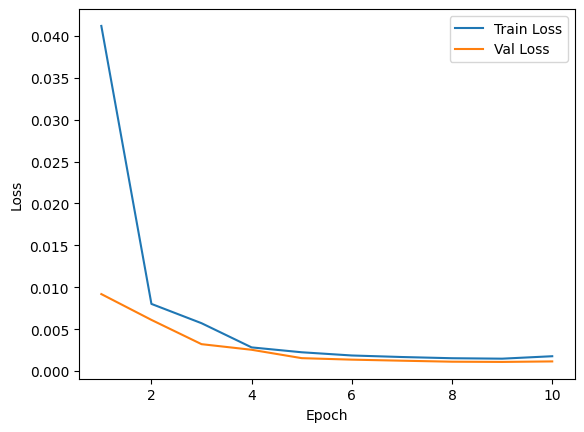

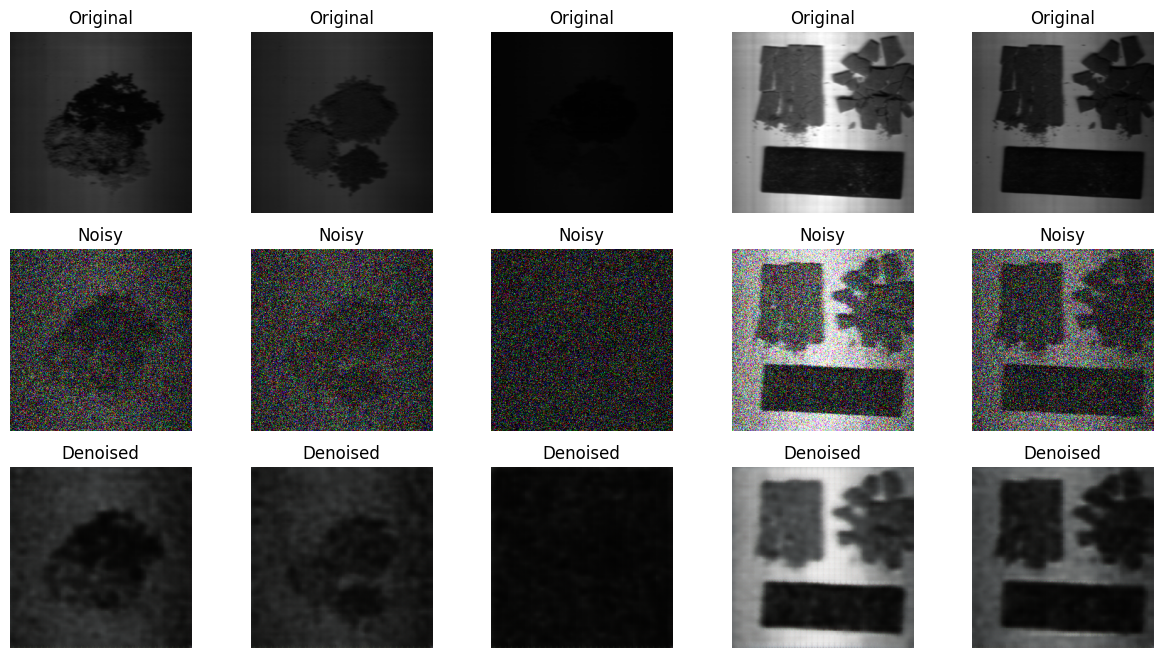

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor()
])

# Load Dataset
dataset = NoisyImageDataset(root_dir="/kaggle/input/near-infrared-hyperspectral-image", transform=transform)

# Split dataset into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize Model, Loss Function, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with validation and tracking loss
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        
        # Forward pass
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in val_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            total_val_loss += loss.item()
    
    # Average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Display a few examples of original, noisy, and denoised images
model.eval()
with torch.no_grad():
    for noisy_imgs, clean_imgs in val_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Display the first few images
        fig, axs = plt.subplots(3, 5, figsize=(15, 8))
        for i in range(5):
            axs[0, i].imshow(clean_imgs[i].cpu().permute(1, 2, 0))
            axs[0, i].set_title("Original")
            axs[0, i].axis("off")
            
            axs[1, i].imshow(noisy_imgs[i].cpu().permute(1, 2, 0))
            axs[1, i].set_title("Noisy")
            axs[1, i].axis("off")
            
            axs[2, i].imshow(outputs[i].cpu().permute(1, 2, 0))
            axs[2, i].set_title("Denoised")
            axs[2, i].axis("off")
        
        break  # Display only the first batch


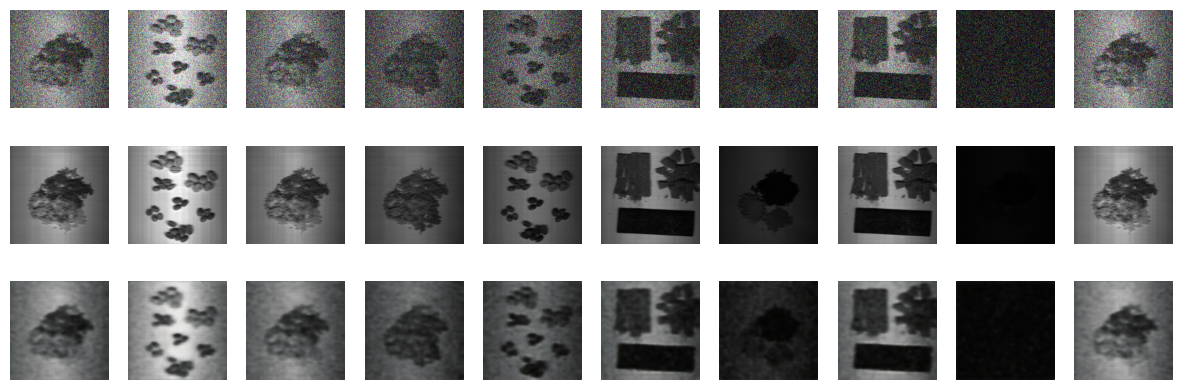

In [11]:
# Switch to evaluation mode
model.eval()
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
with torch.no_grad():
    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Display original, noisy, and denoised images
        for j in range(10):
            if j >= len(noisy_imgs): break
            axes[0, j].imshow(noisy_imgs[j].cpu().permute(1, 2, 0))
            axes[1, j].imshow(clean_imgs[j].cpu().permute(1, 2, 0))
            axes[2, j].imshow(outputs[j].cpu().permute(1, 2, 0))
            for ax in axes[:, j]: ax.axis('off')
        if i >= 0: break
plt.show()


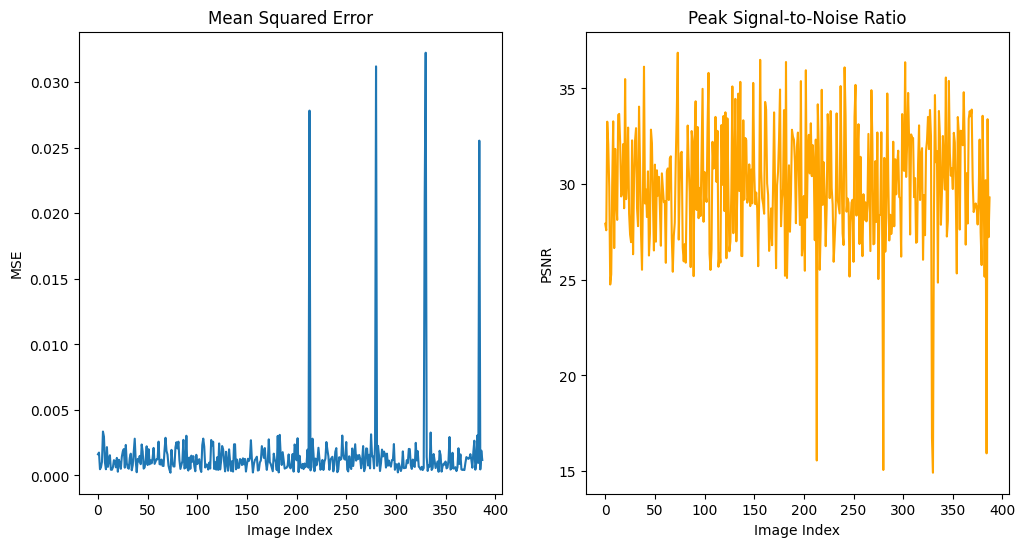

In [12]:
from sklearn.metrics import mean_squared_error
import math

def calculate_psnr(img1, img2):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0: return 100
    return 20 * math.log10(1.0 / math.sqrt(mse))

mse_values = []
psnr_values = []
model.eval()

with torch.no_grad():
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Calculate MSE and PSNR
        for i in range(len(clean_imgs)):
            mse = criterion(outputs[i], clean_imgs[i]).item()
            psnr = calculate_psnr(clean_imgs[i].cpu().numpy(), outputs[i].cpu().numpy())
            
            mse_values.append(mse)
            psnr_values.append(psnr)

# Plot MSE and PSNR curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mse_values, label="MSE")
plt.title("Mean Squared Error")
plt.xlabel("Image Index")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.plot(psnr_values, label="PSNR", color="orange")
plt.title("Peak Signal-to-Noise Ratio")
plt.xlabel("Image Index")
plt.ylabel("PSNR")
plt.show()


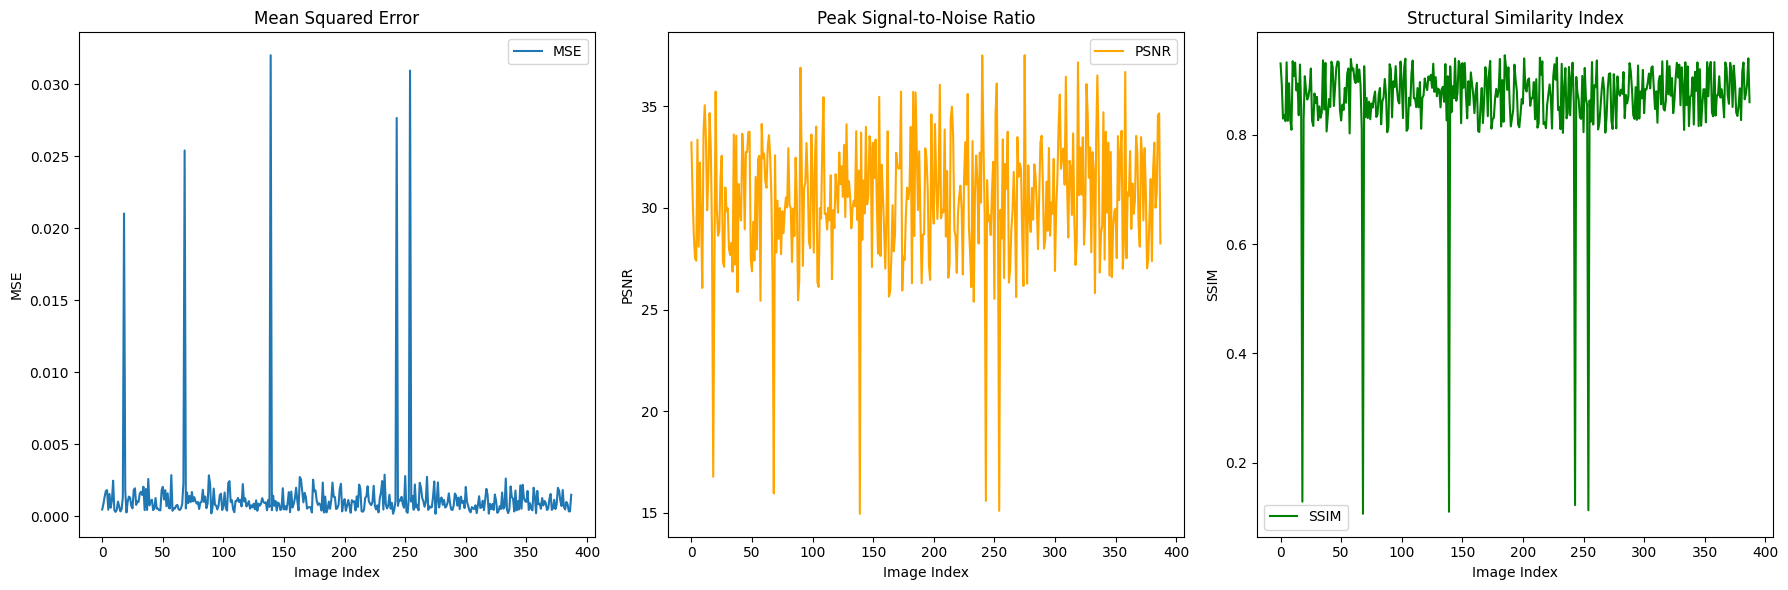

In [38]:
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0: return 100
    return 20 * math.log10(1.0 / math.sqrt(mse))

# Initialize lists to store metrics
mse_values = []
psnr_values = []
ssim_values = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Calculate MSE, PSNR, and SSIM for each image in the batch
        for i in range(len(clean_imgs)):
            # Convert tensors to numpy arrays
            clean_img_np = clean_imgs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            output_img_np = outputs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            
            # Calculate MSE
            mse = mean_squared_error(clean_img_np.flatten(), output_img_np.flatten())
            psnr = calculate_psnr(clean_img_np, output_img_np)
            
            # Calculate SSIM with a smaller window size (for small images) and specify data_range
            ssim_value = ssim(clean_img_np, output_img_np, multichannel=True, win_size=3, data_range=1.0)
            
            mse_values.append(mse)
            psnr_values.append(psnr)
            ssim_values.append(ssim_value)

# Plot MSE, PSNR, and SSIM curves
plt.figure(figsize=(18, 6))

# MSE plot
plt.subplot(1, 3, 1)
plt.plot(mse_values, label="MSE")
plt.title("Mean Squared Error")
plt.xlabel("Image Index")
plt.ylabel("MSE")
plt.legend()

# PSNR plot
plt.subplot(1, 3, 2)
plt.plot(psnr_values, label="PSNR", color="orange")
plt.title("Peak Signal-to-Noise Ratio")
plt.xlabel("Image Index")
plt.ylabel("PSNR")
plt.legend()

# SSIM plot
plt.subplot(1, 3, 3)
plt.plot(ssim_values, label="SSIM", color="green")
plt.title("Structural Similarity Index")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.legend()

plt.tight_layout()
plt.show()


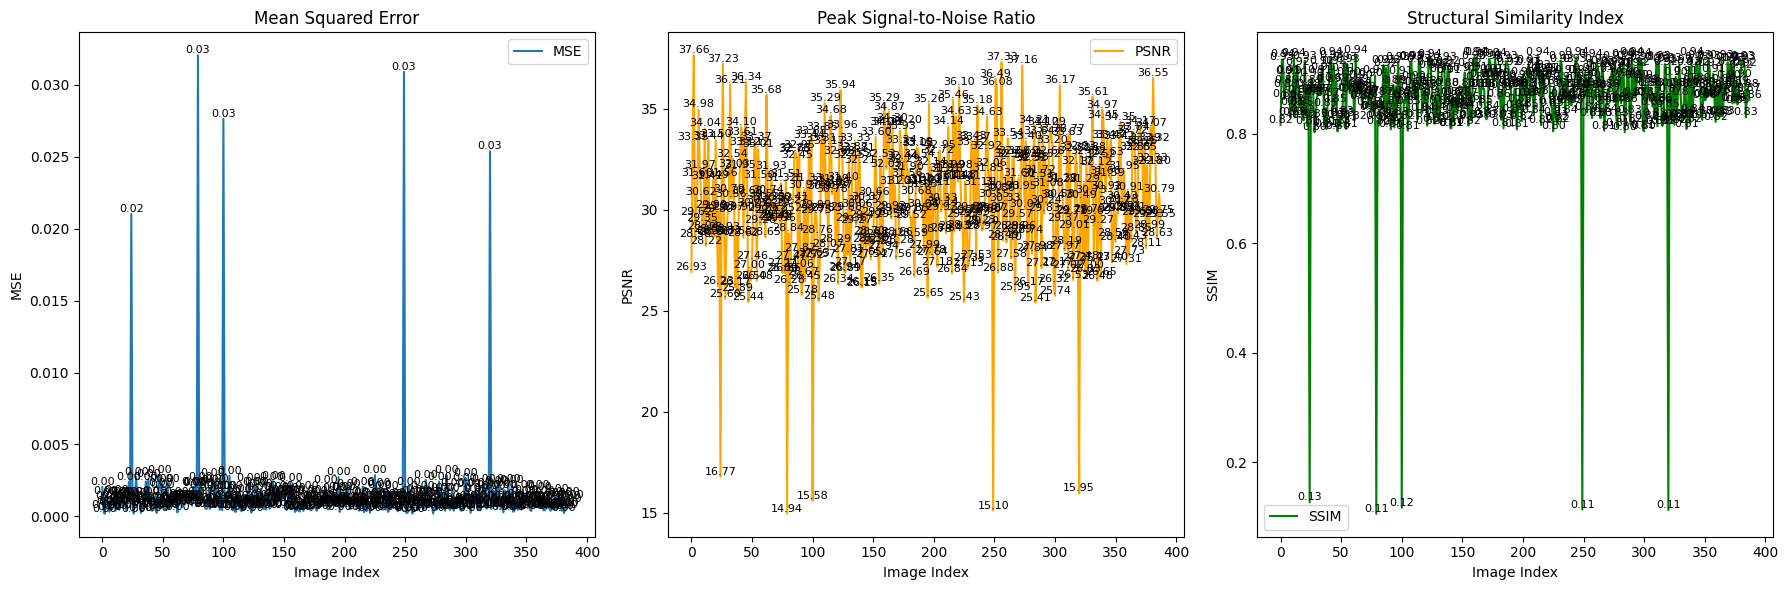

In [39]:
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0: return 100
    return 20 * math.log10(1.0 / math.sqrt(mse))

# Initialize lists to store metrics
mse_values = []
psnr_values = []
ssim_values = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Calculate MSE, PSNR, and SSIM for each image in the batch
        for i in range(len(clean_imgs)):
            # Convert tensors to numpy arrays
            clean_img_np = clean_imgs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            output_img_np = outputs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            
            # Calculate MSE
            mse = mean_squared_error(clean_img_np.flatten(), output_img_np.flatten())
            psnr = calculate_psnr(clean_img_np, output_img_np)
            
            # Calculate SSIM with a smaller window size (for small images) and specify data_range
            ssim_value = ssim(clean_img_np, output_img_np, multichannel=True, win_size=3, data_range=1.0)
            
            mse_values.append(mse)
            psnr_values.append(psnr)
            ssim_values.append(ssim_value)

# Plot MSE, PSNR, and SSIM curves
plt.figure(figsize=(18, 6))

# MSE plot
plt.subplot(1, 3, 1)
plt.plot(mse_values, label="MSE")
plt.title("Mean Squared Error")
plt.xlabel("Image Index")
plt.ylabel("MSE")
plt.legend()

# Print MSE values on the plot
for i, mse in enumerate(mse_values):
    plt.text(i, mse, f'{mse:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='center')

# PSNR plot
plt.subplot(1, 3, 2)
plt.plot(psnr_values, label="PSNR", color="orange")
plt.title("Peak Signal-to-Noise Ratio")
plt.xlabel("Image Index")
plt.ylabel("PSNR")
plt.legend()

# Print PSNR values on the plot
for i, psnr in enumerate(psnr_values):
    plt.text(i, psnr, f'{psnr:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='center')

# SSIM plot
plt.subplot(1, 3, 3)
plt.plot(ssim_values, label="SSIM", color="green")
plt.title("Structural Similarity Index")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.legend()

# Print SSIM values on the plot
for i, ssim_value in enumerate(ssim_values):
    plt.text(i, ssim_value, f'{ssim_value:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='center')

plt.tight_layout()
plt.show()


In [42]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0: return 100
    return 20 * math.log10(1.0 / math.sqrt(mse))

# Initialize lists to store metrics
mse_values = []
psnr_values = []
ssim_values = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Calculate MSE, PSNR, and SSIM for each image in the batch
        for i in range(len(clean_imgs)):
            # Convert tensors to numpy arrays
            clean_img_np = clean_imgs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            output_img_np = outputs[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
            
            # Calculate MSE
            mse = mean_squared_error(clean_img_np.flatten(), output_img_np.flatten())
            psnr = calculate_psnr(clean_img_np, output_img_np)
            
            # Calculate SSIM with a smaller window size (for small images) and specify data_range
            ssim_value = ssim(clean_img_np, output_img_np, multichannel=True, win_size=3, data_range=1.0)
            
            mse_values.append(mse)
            psnr_values.append(psnr)
            ssim_values.append(ssim_value)

# Create a pandas DataFrame to display the first 20 values
metrics_df = pd.DataFrame({
    'MSE': mse_values[:50],
    'PSNR': psnr_values[:50],
    'SSIM': ssim_values[:50]
})

# Print the first 20 values in tabular form
print(metrics_df)


         MSE       PSNR      SSIM
0   0.001557  28.077509  0.826666
1   0.001665  27.785714  0.832029
2   0.000788  31.033869  0.878996
3   0.000358  34.461440  0.929359
4   0.001988  27.015651  0.841459
5   0.001287  28.905171  0.869354
6   0.001722  27.640132  0.848243
7   0.000651  31.863614  0.900620
8   0.000553  32.569030  0.924384
9   0.000684  31.650600  0.893795
10  0.001547  28.106307  0.857541
11  0.000532  32.738535  0.922774
12  0.002682  25.714929  0.804098
13  0.000986  30.059926  0.861659
14  0.000416  33.804094  0.935791
15  0.000891  30.499470  0.878835
16  0.001745  27.582649  0.851203
17  0.000812  30.905981  0.895175
18  0.001105  29.567002  0.879989
19  0.000733  31.351577  0.832351
20  0.000477  33.217906  0.930403
21  0.000397  34.007690  0.940028
22  0.001008  29.963272  0.865159
23  0.000355  34.500317  0.894281
24  0.001062  29.740612  0.865178
25  0.000537  32.700626  0.924378
26  0.000409  33.880930  0.926276
27  0.002469  26.075402  0.812976
28  0.000643  

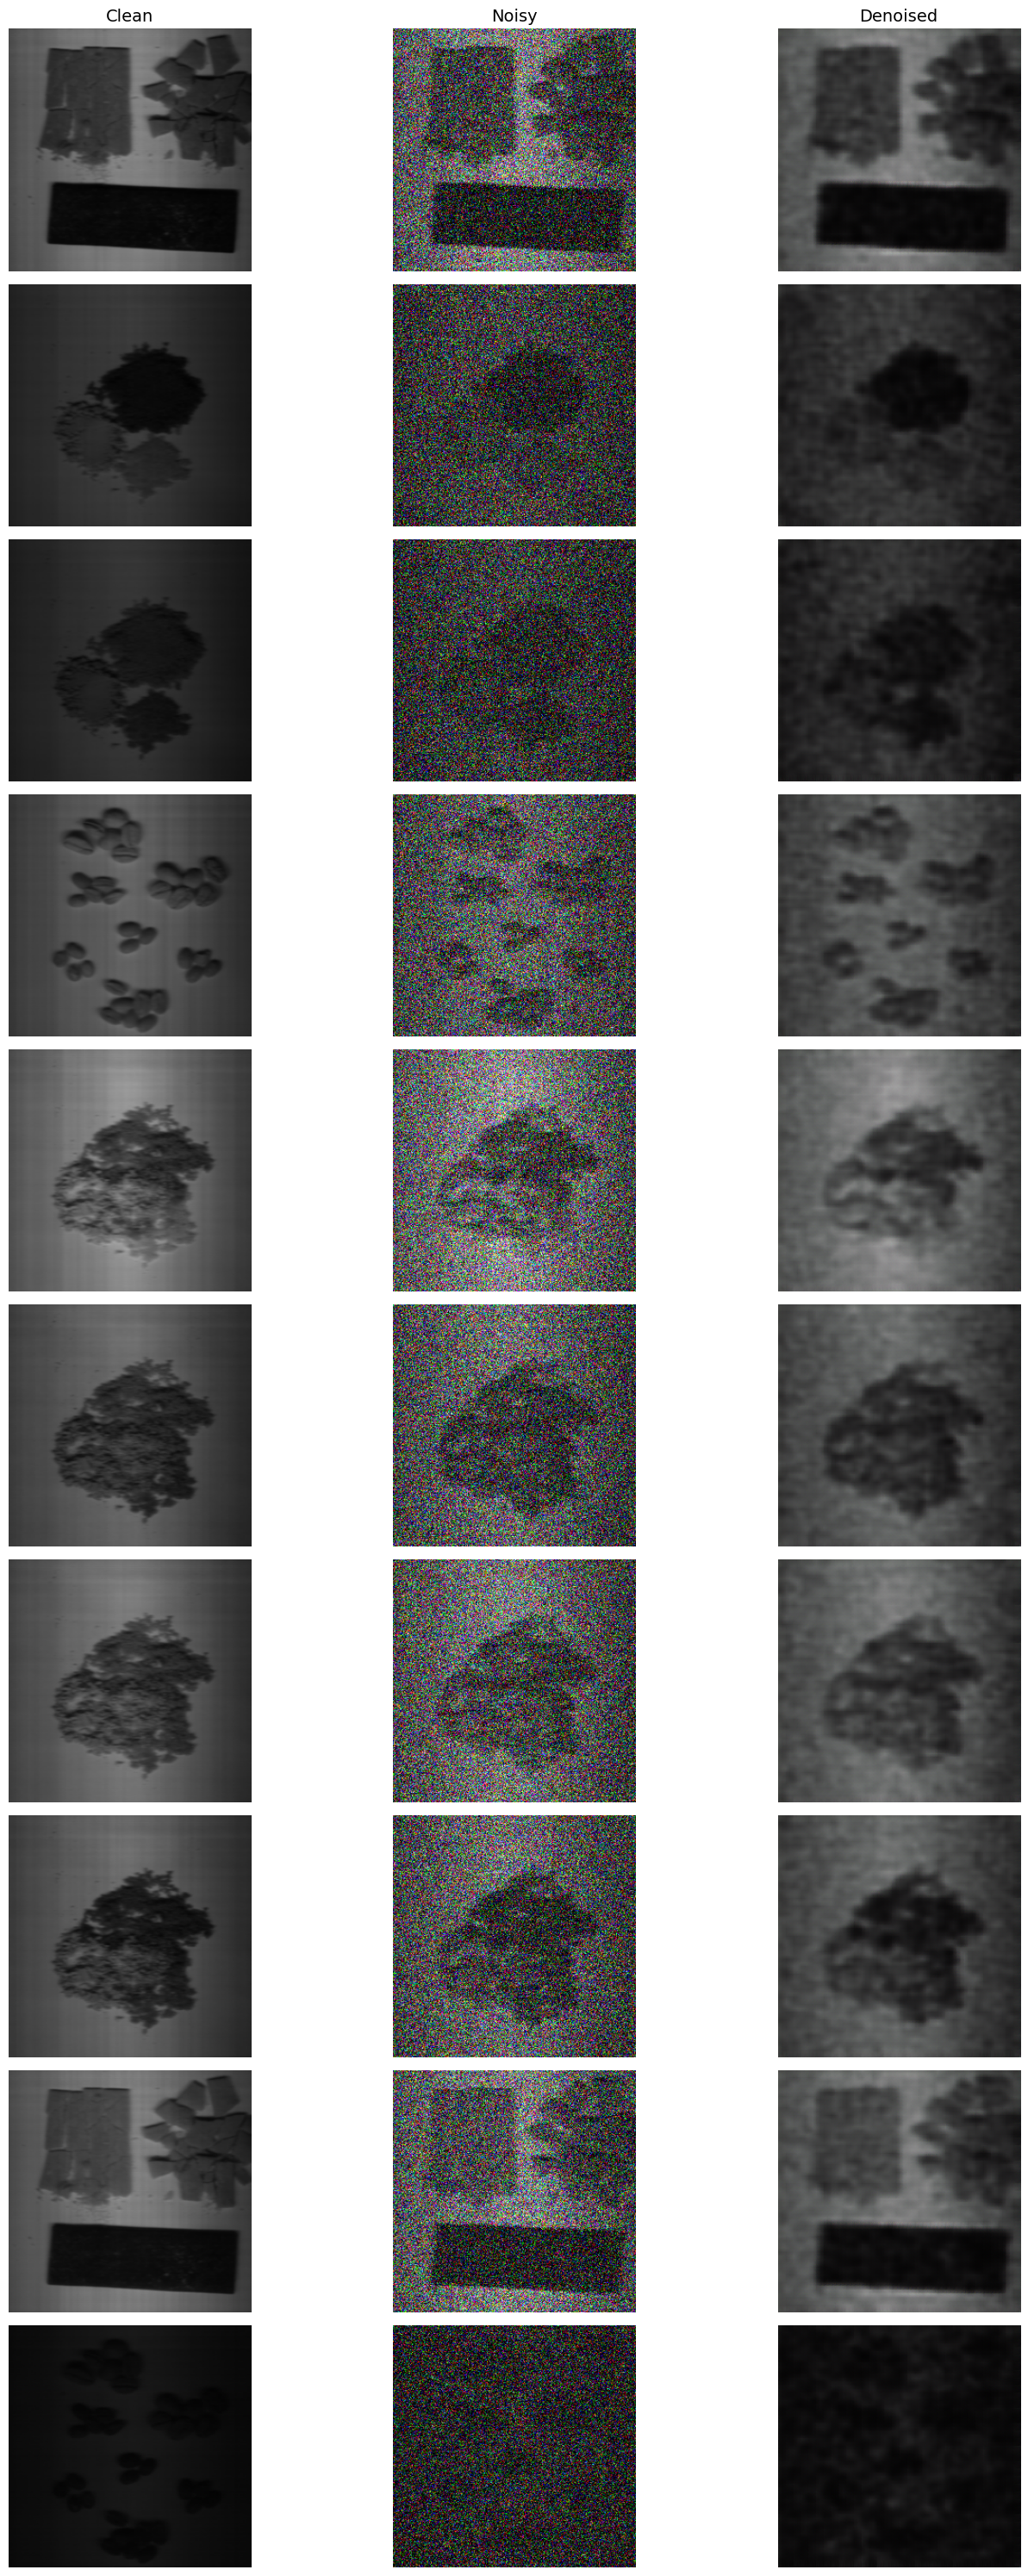

In [46]:
import matplotlib.pyplot as plt
import torch

# Switch to evaluation mode
model.eval()

# Increase the axes to 10 rows
fig, axes = plt.subplots(10, 3, figsize=(15, 30))  # 10 rows and 3 columns for noisy, clean, and denoised images

with torch.no_grad():
    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        
        # Add titles to columns
        axes[0, 0].set_title('Clean', fontsize=14)
        axes[0, 1].set_title('Noisy', fontsize=14)
        axes[0, 2].set_title('Denoised', fontsize=14)

        # Display original, noisy, and denoised images
        for j in range(10):  # Display up to 10 images
            if j >= len(noisy_imgs): break
            
            # Display noisy image
            axes[j, 0].imshow(clean_imgs[j].cpu().permute(1, 2, 0))
            axes[j, 0].axis('off')  # Turn off axis for the noisy image
            
            # Display clean image
            axes[j, 1].imshow(noisy_imgs[j].cpu().permute(1, 2, 0))
            axes[j, 1].axis('off')  # Turn off axis for the clean image
            
            # Display denoised image
            axes[j, 2].imshow(outputs[j].cpu().permute(1, 2, 0))
            axes[j, 2].axis('off')  # Turn off axis for the denoised image
        
        if i >= 0: break  # Stop after displaying the first batch

plt.tight_layout()  # To prevent overlap and adjust spacing
plt.show()


In [14]:
!pip install torchsummary

In [47]:
from torchsummary import summary

# Assuming 'model' is your network
model.to(device)  # Ensure the model is moved to the correct device (CPU or GPU)

# Print the summary for the model
summary(model, input_size=(3, 256, 256))  # Modify input size based on your model's expected input dimensions


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
              ReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         295,168
              ReLU-6          [-1, 256, 32, 32]               0
   ConvTranspose2d-7          [-1, 128, 64, 64]         295,040
              ReLU-8          [-1, 128, 64, 64]               0
   ConvTranspose2d-9         [-1, 64, 128, 128]          73,792
             ReLU-10         [-1, 64, 128, 128]               0
  ConvTranspose2d-11          [-1, 3, 256, 256]           1,731
          Sigmoid-12          [-1, 3, 256, 256]               0
Total params: 741,379
Trainable params: 741,379
Non-trainable params: 0
-------------------------------